In [ ]:
#the statistics of the eclipse data

In [1]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import ast

from global_functions import *

In [2]:
release_creation_ts_all = get_release_dates()

In [3]:
#Load data
df = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_info.csv',index_col=False,dtype={'version':str,'release':str})
df = df.fillna('')
df = trans_to_datetime(df,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])
df.head(n=2)

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaT,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,,0,0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaT,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,,0,0,4.6,4.6,False,False


In [4]:
yearly_file = '.'+os.sep+'data'+os.sep+'bugs_info.csv'
df_yearly = pd.read_csv(yearly_file,index_col=False,dtype={'version':str,'release':str})

In [5]:
df_yearly.head()

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaN,...,2015-08-19 11:53:03,2015-08-19 11:53:03,2015-08-19 11:53:03,NaN,0.0,0.0,4.5,4.5,False,False
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaN,...,2015-08-26 14:29:30,2015-08-26 14:29:30,2015-08-26 14:29:30,NaN,0.0,0.0,4.6,4.6,False,False
2,475370,4.5,Platform,2015-08-19 12:09:06,4.5,DUPLICATE,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
3,475379,4.5,Platform,2015-08-19 13:39:12,4.5,NaN,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.5,False,False
4,475407,4.5,Platform,2015-08-19 17:06:10,4.5,FIXED,0,1,1,NaN,...,2015-08-19 17:15:25,2015-08-19 17:15:25,2015-08-19 17:15:25,NaN,0.0,0.0,4.5,4.5,False,False


In [6]:
df_yearly.release.unique()

array(['4.5', '4.6', '4.4', '3.7', '4.2', '4.3', '3.6', '4.8', '3.1',
       '4.7', '4.10', '3.4', '3.5', '3.3', '3.2', '3.0', '4.9'],
      dtype=object)

In [7]:
def get_triaging_statistics_per_release(df_w,assignedFirst,resolvedFirst):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if resolvedFirst:
        resolve_column = 'first_resolved_date'
    else:
        resolve_column = 'last_resolved_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[version_bugs['creation_time']<start_date]
        
        #the bug after release 
        bugs_after_release = version_bugs[version_bugs['creation_time']>= start_date]
        
        #the bug created and assigned & before release 
        bugs_created_assigned_before_release = (
            version_bugs[(version_bugs['creation_time'] < start_date) &
                        (version_bugs[assingment_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_assigned_after_release = (
            version_bugs[(version_bugs['creation_time'] < start_date) &
                        (version_bugs[assingment_column] > start_date)]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_assigned = (
            version_bugs[(version_bugs['creation_time'] >= start_date) &
                        (version_bugs['is_assigned'] > 0)]
        )

        before_release = len(bugs_before_release.id.unique())
        RBAB= bugs_created_assigned_before_release.id.unique().tolist()
        RBAA = bugs_created_assigned_before_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAAA = bugs_created_after_release_assigned.id.unique().tolist()
        
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBAB':str(RBAB), 
                           'RBAA':str(RBAA), 
                           'RAAA':str(RAAA)
                           },ignore_index=True)
    return df_ret

In [8]:
target_file = '.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'year_releases_yearly_stats_first_assign.csv'
if not os.path.exists(target_file):
    df_yearly_stats_first = get_triaging_statistics_per_release(df_yearly,assignedFirst=True,resolvedFirst=False)
    df_yearly_stats_first.to_csv(target_file,index=False)
else:
    df_yearly_stats_first = pd.read_csv(target_file,index_col=False,
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first["RAAA"]  = df_yearly_stats_first["RAAA"].apply(ast.literal_eval)
    df_yearly_stats_first["RBAA"]  = df_yearly_stats_first["RBAA"].apply(ast.literal_eval)
    df_yearly_stats_first["RBAB"]  = df_yearly_stats_first["RBAB"].apply(ast.literal_eval)
    
df_yearly_stats_first['version'] = df_yearly_stats_first['version'].astype(str)
df_yearly_stats_first = sort_df(df_yearly_stats_first,'version')
df_yearly_stats_first.head()

,version,RAAA,RBAA,RBAB,after_release,before_release,total
0,3.0,"[185790, 101046, 101423, 101428, 101447, 10150...","[28440, 29422, 18608, 64617, 64621, 64626, 646...","[28440, 29422, 18608, 64617, 64621, 64626, 646...",6970.0,17967.0,24937.0
1,3.1,"[245789, 246565, 249954, 187986, 101968, 10200...","[100814, 100822, 100825, 100826, 100829, 10088...","[100814, 100822, 100825, 100826, 100829, 10088...",5718.0,12190.0,17908.0
2,3.2,"[244723, 245552, 246887, 248110, 248410, 24856...","[101152, 102024, 103299, 103380, 103710, 10407...","[101152, 102024, 103299, 103380, 103710, 10407...",5354.0,10480.0,15834.0
3,3.3,"[244440, 244476, 244815, 245312, 245575, 24597...","[183607, 183610, 183621, 183640, 183732, 18376...","[183607, 183610, 183621, 183640, 183732, 18376...",4550.0,8092.0,12642.0
4,3.4,"[244396, 244397, 244407, 244409, 244425, 24442...","[115163, 236612, 236634, 236669, 236724, 23673...","[115163, 236612, 236634, 236669, 236724, 23673...",4579.0,7931.0,12510.0


In [9]:
df=df_yearly.copy()

In [10]:
df_yearly_stats_first.version.unique()

array(['3.0', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '4.10'],
      dtype=object)

In [11]:
df_yearly_stats_first.head()

,version,RAAA,RBAA,RBAB,after_release,before_release,total
0,3.0,"[185790, 101046, 101423, 101428, 101447, 10150...","[28440, 29422, 18608, 64617, 64621, 64626, 646...","[28440, 29422, 18608, 64617, 64621, 64626, 646...",6970.0,17967.0,24937.0
1,3.1,"[245789, 246565, 249954, 187986, 101968, 10200...","[100814, 100822, 100825, 100826, 100829, 10088...","[100814, 100822, 100825, 100826, 100829, 10088...",5718.0,12190.0,17908.0
2,3.2,"[244723, 245552, 246887, 248110, 248410, 24856...","[101152, 102024, 103299, 103380, 103710, 10407...","[101152, 102024, 103299, 103380, 103710, 10407...",5354.0,10480.0,15834.0
3,3.3,"[244440, 244476, 244815, 245312, 245575, 24597...","[183607, 183610, 183621, 183640, 183732, 18376...","[183607, 183610, 183621, 183640, 183732, 18376...",4550.0,8092.0,12642.0
4,3.4,"[244396, 244397, 244407, 244409, 244425, 24442...","[115163, 236612, 236634, 236669, 236724, 23673...","[115163, 236612, 236634, 236669, 236724, 23673...",4579.0,7931.0,12510.0


In [12]:
traiging_time_RBAB=pd.DataFrame()
traiging_time_RBAA=pd.DataFrame()
traiging_time_RAAA=pd.DataFrame()
for index, row in df_yearly_stats_first.iterrows():
    #the bug created and assigned & before release 
    df_b=df[df.id.isin(row['RBAB'])]
    
    df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])
    df_b['triaging_time'] =df_b.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
    df_b= df_b[['id',
     'first_assignment_date',
     'triaging_time' ,'release' ]]
    df_b['done'] = '1'
    traiging_time_RBAB=traiging_time_RBAB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df[df.id.isin(row['RAAA'])]
    df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
    df_a['triaging_time'] =df_a.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
   
    df_a= df_a[['id',
     'first_assignment_date',
     'triaging_time',
        'release']]
    df_a['done'] = '1'
    traiging_time_RAAA=traiging_time_RAAA.append(df_a)
    
    #
traiging_time_RBAB.to_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'Eclipse-RBAB.csv',index=False)    
traiging_time_RAAA.to_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'Eclipse-RAAA.csv',index=False)

C:\Users\zeinab\Papers\26-3-2019\msr2019\rep-pack\global_functions.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dd[col] = pd.to_datetime(dd[col])
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [16]:

RBAB = pd.read_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'Eclipse-RBAB.csv',
                dtype={'release':str,'version':str})
RAAA = pd.read_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'Eclipse-RAAA.csv',
                dtype={'release':str,'version':str})

In [23]:
y=RBAB[RBAB['release']=='4.10'].id.unique()

In [31]:
mydf= df[df['id'].isin(y)]

In [32]:
mydf[mydf['id']==477268]

,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_resolved_date,first_fixed_date,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field
127495,477268,4.10,PDE,2015-09-12 23:24:04,4.10,FIXED,1,1,1,2018-11-20 15:49:53,...,2019-01-07 10:46:43,2019-01-07 10:46:43,2019-01-07 10:46:43,0.0,0.0,0.0,4.1,4.1,False,False


In [27]:
df.columns

Index(['id', 'release', 'Product', 'creation_time', 'version', 'resolution',
       'is_assigned', 'is_resolved', 'is_fixed', 'first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date', 'time_assign_diff',
       'time_resolve_diff', 'time_fix_diff', 'min_release', 'max_release',
       'min_release_before_version_field', 'min_release_after_version_field'],
      dtype='object')

In [28]:
mydf=trans_to_datetime(mydf,['creation_time','first_assignment_date'])

mydf['triaging_time'] =mydf.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
mydf= mydf[['id',
 'first_assignment_date',
 'triaging_time' ,'release' ]]
mydf['done'] = '1'
#traiging_time_RBAB=traiging_time_RBAB.append(df_b)

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
mydf.head()

,id,first_assignment_date,triaging_time,release,done
25725,540097,2018-10-13 03:18:58,0,4.10,1
25747,540200,2018-10-17 19:32:40,0,4.10,1
25758,540260,2018-10-18 15:35:49,0,4.10,1
25794,540474,2018-11-09 09:44:52,14,4.10,1
25805,540580,2018-12-07 08:18:51,38,4.10,1


6463 6463
2649 2649


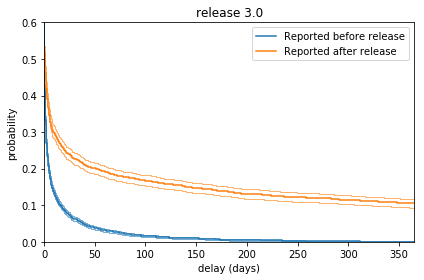

4197 4197
2027 2027


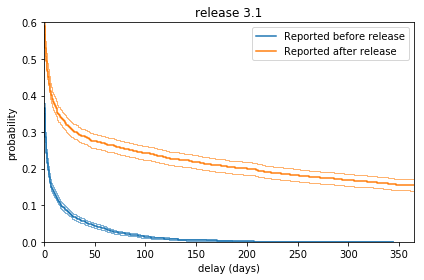

3819 3819
1859 1859


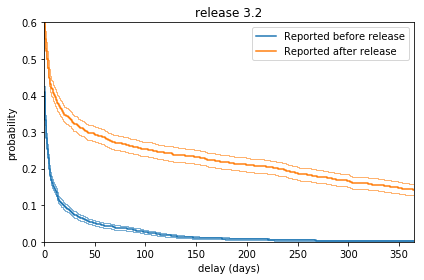

2815 2815
1586 1586


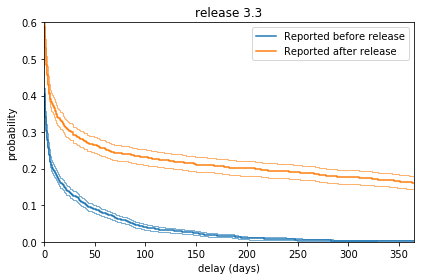

2405 2405
1591 1591


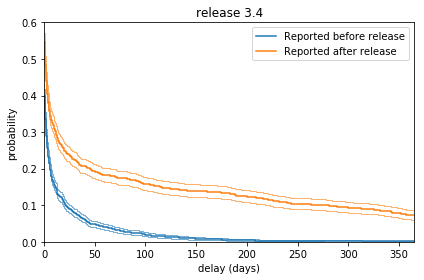

2237 2237
1026 1026


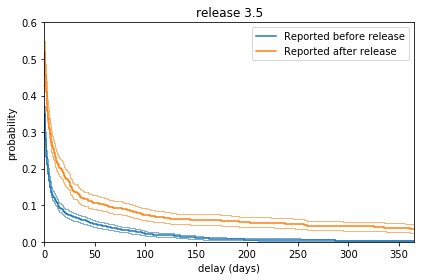

1480 1480
728 728


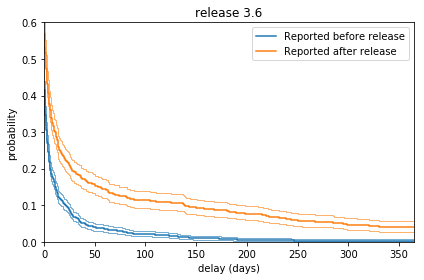

1029 1029
618 618


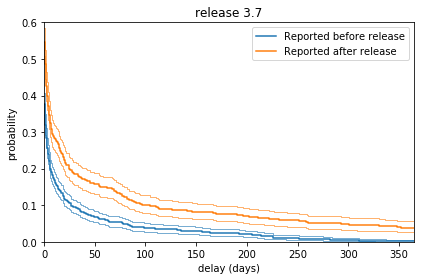

974 974
1503 1503


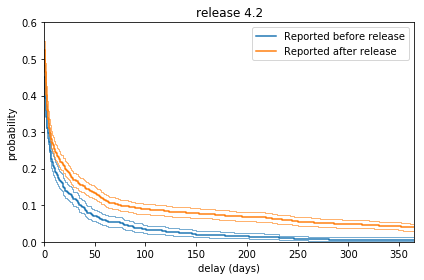

653 653
784 784


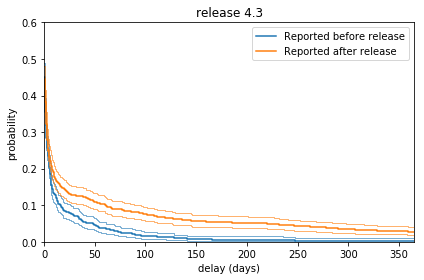

1235 1235
768 768


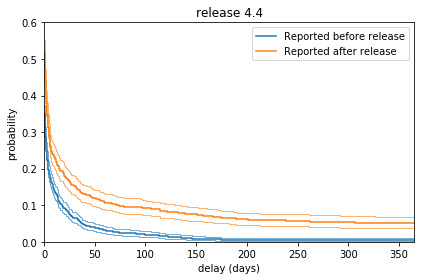

809 809
738 738


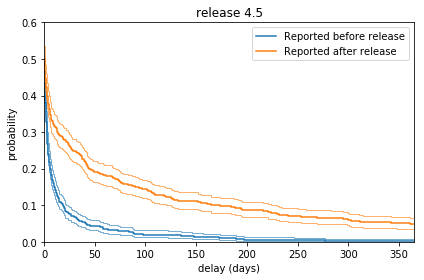

615 615
616 616


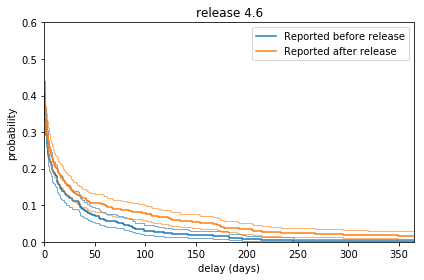

830 830
669 669


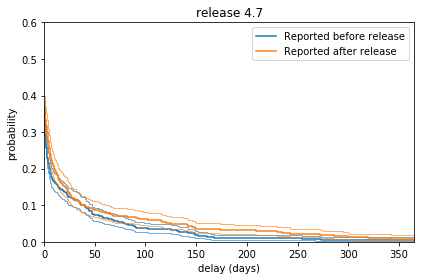

766 766
139 139


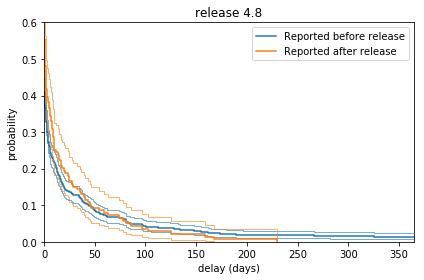

113 113
110 110


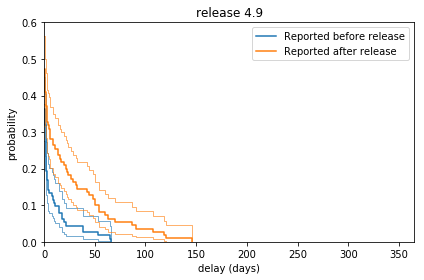

116 116
53 53


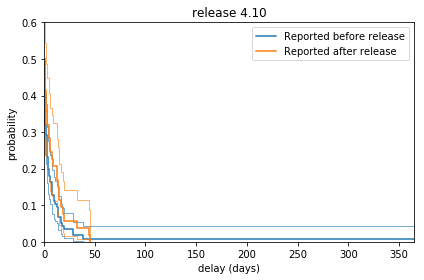

In [15]:
kmf = KaplanMeierFitter()
RBAB = pd.read_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'Eclipse-RBAB.csv',
                dtype={'release':str,'version':str})
RAAA = pd.read_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'Eclipse-RAAA.csv',
                dtype={'release':str,'version':str})
time=['Reported before release','Reported after release']

for release in RBAB.release.unique():
    ax = plt.subplot(1, 1,1)
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T = dat["triaging_time"]
            E = dat["done"]
            print(len(T),len(E))
            kmf.fit( T, E, label=time[j-1])
            kmf.plot(ax=ax, ci_force_lines=True)
            ax.set_xlabel("delay (days)")
            ax.set_ylabel("probability")
 
    plt.title('release '+version)
    plt.xlim(0, 365)
    plt.ylim(0, 0.6)

    plt.savefig('..'+os.sep+'paper'+os.sep+'temp_figs'+os.sep+'xrq2t_'+version.replace('.', '_')+'.pdf')
    
    plt.tight_layout( )
    plt.show()




In [ ]:
#logrank test

In [86]:
RBAB = pd.read_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'Eclipse-RBAB.csv',
                dtype={'release':str,'version':str})
RAAA = pd.read_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'Eclipse-RAAA.csv',
                dtype={'release':str,'version':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)

pData=pd.DataFrame()
T=[None] * 2
E=[None] * 2
results=[None] * 9
for release in RBAB.release.unique():
    i=0
    
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    k=0
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T[k] = dat["triaging_time"]
            E[k] = dat["done"]
            k=k+1
    results[i] = logrank_test(T[0], T[1], E[0], E[1], alpha=.95).p_value
    pDat=pd.DataFrame({'version': [release] , 'p':[results[i]] })

    #print(version)
    pData=pData.append(pDat)
 


In [87]:
pData= pData[['version' , 'p']]
pData

,version,p
0,3.0,6.964255e-150
0,3.1,6.090665e-205
0,3.2,1.036187e-179
0,3.3,1.216030e-98
0,3.4,6.500741e-65
0,3.5,2.891894e-27
0,3.6,5.188191e-27
0,3.7,3.221060e-14
0,4.2,1.359152e-08
0,4.3,5.179842e-05


In [88]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'accept H0')

In [89]:
pData

,version,p,H0
0,3.0,6.964255e-150,reject H0
0,3.1,6.090665e-205,reject H0
0,3.2,1.036187e-179,reject H0
0,3.3,1.216030e-98,reject H0
0,3.4,6.500741e-65,reject H0
0,3.5,2.891894e-27,reject H0
0,3.6,5.188191e-27,reject H0
0,3.7,3.221060e-14,reject H0
0,4.2,1.359152e-08,reject H0
0,4.3,5.179842e-05,reject H0


In [90]:
print(pData[['version','H0']].to_latex(index=False))

\begin{tabular}{ll}
\toprule
version &         H0 \\
\midrule
    3.0 &  reject H0 \\
    3.1 &  reject H0 \\
    3.2 &  reject H0 \\
    3.3 &  reject H0 \\
    3.4 &  reject H0 \\
    3.5 &  reject H0 \\
    3.6 &  reject H0 \\
    3.7 &  reject H0 \\
    4.2 &  reject H0 \\
    4.3 &  reject H0 \\
    4.4 &  reject H0 \\
    4.5 &  reject H0 \\
    4.6 &  accept H0 \\
    4.7 &  accept H0 \\
    4.8 &  accept H0 \\
    4.9 &  reject H0 \\
   4.10 &  accept H0 \\
\bottomrule
\end{tabular}



In [91]:
pData.to_csv('.'+os.sep+'data'+os.sep+'RQ2'+os.sep+'logrank_test.csv',index=False)